In [15]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import warnings
from scipy.optimize import newton, minimize, fsolve

In [16]:

def tRNA_charge(y, t, rates):
    '''
    Solution to the enzyme kinetics
    of aminoacylation of a tRNA.
    '''
    # S  = Substrate (tRNA)
    # E  = Enzyme (aminoacyl tRNA ligase)
    # ES = Enzyme:substrate complex
    # P  = Product (aminoacylated tRNA)
    # T  = Product binding partner (EF-Tu)
    # PT = Product:binding partner
    k1, k_1, k2, k3, k4, k_4, k5 = rates
    T, S, E, ES, P, PT = y
    
    dTdt  = - k4*P*T + k_4*PT + k5*PT
    dSdt  = - k1*S*E + k_1*ES + k3*P   + k5*PT
    dEdt  = - k1*S*E + k_1*ES + k2*ES
    dESdt =   k1*E*S - k_1*ES - k2*ES
    dPdt  =   k2*ES  - k3*P   - k4*P*T + k_4*PT
    dPTdt =   k4*P*T - k_4*PT - k5*PT
    
    dydt = [dTdt, dSdt, dEdt, dESdt, dPdt, dPTdt]
    return dydt


'''
Non-vectorized solution to the tRNA charge kinetics
with N different tRNAs.
Keeping this as a reference because it is more
transparent/easier to read than the faster
vectorized solution.

def tRNA_charge_n(y, t, k1_arr, k_1_arr, rates):
    k2, k3, k4, k_4, k5 = rates
    T = y[-2]
    E = y[-1]
    dydt = list()
    
    N = (len(y)-2) // 4
    i = 0
    dTdt = 0
    dEdt = 0
    for n in range(0, N):
        # S, ES, P, PT
        S = y[i]
        ES = y[i+1]
        P = y[i+2]
        PT = y[i+3]
        k1 = k1_arr[n]
        k_1 = k_1_arr[n]
        
        dSdt  = - k1*S*E + k_1*ES + k3*P   + k5*PT
        dESdt =   k1*E*S - k_1*ES - k2*ES
        dPdt  =   k2*ES  - k3*P   - k4*P*T + k_4*PT
        dPTdt =   k4*P*T - k_4*PT - k5*PT
        dydt.extend([dSdt, dESdt, dPdt, dPTdt])
        
        dTdt  += - k4*P*T + k_4*PT + k5*PT
        dEdt  += - k1*S*E + k_1*ES + k2*ES
        
        i += 4
    dydt.extend([dTdt, dEdt])
    
    return dydt
'''

def tRNA_charge_n(y, t, k1_arr, k_1_arr, rates):
    '''
    Vectorized solution to the enzyme kinetics
    of aminoacylation on a pool of N different tRNAs.
    '''
    
    # Ordered as: S, ES, P, PT
    # Finished by: T and E
    k2, k3, k4, k_4, k5 = rates
    T = y[-2]
    E = y[-1]
    dydt = np.zeros(len(y))
    dydt[0:-2:4] = - k1_arr*y[0:-2:4]*E + k_1_arr*y[1:-2:4] + k3*y[2:-2:4]   + k5*y[3:-2:4]
    dydt[1:-2:4] =   k1_arr*y[0:-2:4]*E - k_1_arr*y[1:-2:4] - k2*y[1:-2:4]
    dydt[2:-2:4] =   k2*y[1:-2:4]   - k3*y[2:-2:4]  - k4*y[2:-2:4]*T + k_4*y[3:-2:4]
    dydt[3:-2:4] =   k4*y[2:-2:4]*T - k_4*y[3:-2:4] - k5*y[3:-2:4]
    dydt[-2] = np.sum(- k4*y[2:-2:4]*T + k_4*y[3:-2:4] + k5*y[3:-2:4])
    dydt[-1] = np.sum(- k1_arr*y[0:-2:4]*E + k_1_arr*y[1:-2:4] + k2*y[1:-2:4])
    
    return(dydt)


def tRNA_charge_p3_n(y, t, k1_arr, k_1_arr, rates):
    '''
    Solution like above but without EF-Tu.
    '''
    # Vectorized solution #
    # Ordered as: S, ES, P
    # Finished by: E
    k2, k3 = rates
    E = y[-1]
    dydt = np.zeros(len(y))
    dydt[0:-1:3] = - k1_arr*y[0:-1:3]*E + k_1_arr*y[1:-1:3] + k3*y[2:-1:3]
    dydt[1:-1:3] =   k1_arr*y[0:-1:3]*E - k_1_arr*y[1:-1:3] - k2*y[1:-1:3]
    dydt[2:-1:3] =   k2*y[1:-1:3]       - k3*y[2:-1:3]
    dydt[-1] = np.sum(- k1_arr*y[0:-1:3]*E + k_1_arr*y[1:-1:3] + k2*y[1:-1:3])
    
    return(dydt)




In [17]:
def tRNA_charge_MM(y, t, const):
    '''
    Solution to the enzyme kinetics
    of aminoacylation of a tRNA
    using Michaelis-Menten assumptions.
    
    '''
    Vmax, Km, S0, T0, k3, k5, T_Kd = const
    S = y
    # Assuming instantaneous equilibrium between
    # tRNA and EF-Tu:
    Ptot = S0 - S
    PT = Ptot/(1 + T_Kd/T0)
    P = Ptot - PT

    dSdt = - Vmax*S/(Km+S) + k3*P + k5*PT
    
    return dSdt


def tRNA_charge_MMn(y, t, Km_arr, S0_arr, const):
    '''
    Solution of the above
    with multiple substrates.
    '''
    # Multiple substrates with the same Vmax and EF-Tu Kd:
    def tRNA_i(i, y, Km_arr, S0_arr, const):
        Vmax, T0, k3, k5, T_Kd = const
        Si = y[i]
        Si0 = S0_arr[i]
        # Assuming instantaneous equilibrium between
        # tRNA and EF-Tu:
        Ptot = Si0 - Si
        PT = Ptot/(1 + T_Kd/T0)
        P = Ptot - PT
        # dSdt = - (Vmax * Si/Km_arr[i]) / (1 + sum(S0_arr[j]/Km_arr[j] * (Si/Si0)**(Km_arr[i]/Km_arr[j]) for j in range(len(y)))) + k3*P + k5*PT
        ds = 0
        with warnings.catch_warnings():
            warnings.filterwarnings('error')
            for j in range(len(y)):
                try:
                    ds += S0_arr[j]/Km_arr[j] * (Si/Si0)**(Km_arr[i]/Km_arr[j])
                except:
                    pass
        dSdt = - (Vmax * Si/Km_arr[i]) / (1 + ds) + k3*P + k5*PT
        
        
        return(dSdt)

    dydt = [tRNA_i(i, y, Km_arr, S0_arr, const) for i in range(len(y))]
    
    return dydt

In [18]:
### Rate estimates ###

# Km ~ 10 uM from Wolfson et al. 2002, can decrease >2000 fold with mutations
# k1 => k_on=1e6 binding to the enzyme
# k_1 => k_off=3 unbinding to the enzyme
# k3 => 4.5 min half-life from Wolfson et al. 2002
# k5 => >100 min half-life from Wolfson et al. 2002
# k4 => k_on=1e5 for EF-Tu binding from LaRiviere et al. 2001 (this is constant)
# k_4 => k_off=0.1 for EF-Tu binding from LaRiviere et al. 2001 (this is variable, but likely a lot higher)
# k2 => kcat for irreversible aminoacylation from en.wikipedia.org/wiki/Michaelis%E2%80%93Menten_kinetics (this should be constant regardless of tRNA since the catalytic context is the same due to CCA-ending)
k1 = 1e7
k_1 = 40
k2 = 60 # 1/s (this is adjusted to Wolfson et al. 2002 data)
k3 = 0.693/(4.5*60) # 1/s
k4 = 1e5 # 1/(M*s)
k_4 = 0.1 # 1/s
k5 = 0.693/(100*60) # 1/s


In [178]:
def sol_p5_n_on(k1_arr, S0_arr, t=None):
    k_1_arr = np.array([40]*len(k1_arr))
    k2 = 60
    k3 = 0.693/(4.5*60)
    k4 = 1e5
    k_4 = 0.1
    k5 = 0.693/(100*60)
    rates = np.array([k2, k3, k4, k_4, k5])

    y0 = [s0 if i==0 else 0 for s0 in S0_arr for i in range(4)]
    # EF-Tu in 3x compared to tRNA, enzyme in 1/400x compared to tRNA:
    T0, E0 = sum(S0_arr)*0, sum(S0_arr)/400
    y0.extend([T0, E0])
    y0 = np.array(y0)

    if t is None:
        # t = np.linspace(0, 120, 10000)
        t = np.logspace(0, 11, 1000, base=2)
    sol = odeint(tRNA_charge_n, y0, t, args=(k1_arr, k_1_arr, rates))
    
    return(t, sol)



def wolfson_samples(N_tRNAs, sq_combi=False, t=None, tRNA_conc=5):
    k2 = 60
    k3 = 0.693/(4.5*60)
    k4 = 1e5
    k_4 = 0.1
    k5 = 0.693/(100*60)
    rates = np.array([k2, k3, k4, k_4, k5])
    k1_arr_obs = np.linspace(1e7, 1e4, N_tRNAs)
    k_1_arr_obs = np.linspace(150, 40, N_tRNAs)
    if sq_combi:
        k1_arr = [k1i for i in range(N_tRNAs) for k1i in k1_arr_obs]
        k1_arr = np.array(k1_arr)
        k_1_arr = [k_1i for k_1i in k_1_arr_obs for i in range(N_tRNAs)]
        k_1_arr = np.array(k_1_arr)
        # Starting concentration of tRNAs:
        S0_arr = np.random.normal(1, 0.2, N_tRNAs**2)
    else:
        k1_arr = np.random.choice(k1_arr_obs, N_tRNAs, replace=False)
        k_1_arr = np.random.choice(k_1_arr_obs, N_tRNAs, replace=False)
        # Starting concentration of tRNAs:
        S0_arr = np.random.normal(1, 0.2, N_tRNAs)
    S0_arr[S0_arr < 0] = 1
    S0_arr = S0_arr/sum(S0_arr) * 1e-6 * tRNA_conc
    y0 = [s0 if i==0 else 0 for s0 in S0_arr for i in range(4)]
    # EF-Tu in 3x compared to tRNA, enzyme in 1/1000x compared to tRNA:
    T0, E0 = sum(S0_arr)*3, sum(S0_arr)/1000
    y0.extend([T0, E0])
    y0 = np.array(y0)

    if t is None:
        # t = np.linspace(0, 60*62, 10000)
        t = np.logspace(0, 14, 10000, base=2)
    sol = odeint(tRNA_charge_n, y0, t, args=(k1_arr, k_1_arr, rates))

    return(t, sol)



def sol_p3_n_on(k1_arr, S0_arr, t=None):
    k_1_arr = np.array([40]*len(k1_arr))
    k2 = 60 # 1/s (this is adjusted to Wolfson et al. 2002 data)
    k3 = 0.693/(4.5*60) # 1/s
    rates = np.array([k2, k3])
    E0 = sum(S0_arr)/1000

    y0 = [s0 if i==0 else 0 for s0 in S0_arr for i in range(3)]
    y0.extend([E0])
    y0 = np.array(y0)

    if t is None:
        # t = np.linspace(0, 120, 10000)
        t = np.logspace(0, 11, 1000, base=2)
    sol = odeint(tRNA_charge_p3_n, y0, t, args=(k1_arr, k_1_arr, rates))
    
    return(t, sol)


def fit_p3_n_data(data, Nt, min_k1, S0_arr, t_inp):
    # Objective function:
    def obj_fun(P_S0, S0_arr, t_inp, p):
        _, sol_i = sol_p3_n_on(p, S0_arr, t=t_inp)
        P_S0_i = sol_i[:, 2:-1:3]/sol_i[0, 0:-1:3]
        loss = np.sum(np.power(P_S0 - P_S0_i, 2))
        return(loss)

    P_S0 = data[:, 2:-1:3]/data[0, 0:-1:3]
    # bnds = ((0.1, 1000), )*10
    bnds = tuple([(i, j) if i>0 else (0.1, j) for i, j in zip(np.linspace(min_k1, 1e7, Nt)-50, np.linspace(min_k1, 1e7, Nt)+50)])
    # guess = tuple(np.linspace(1, 100, 10))
    # guess = (50, )*10
    guess = tuple([np.random.choice([i, j]) for i, j in bnds])
    def min_fun(p): return(obj_fun(P_S0, S0_arr, t_inp, p))
    p_fun = minimize(min_fun, guess, method='Powell', bounds=bnds, tol=1)
    # method='Powell' <- slow but gets to the correct result
    # method='L-BFGS-B' <- faster but stops too early

    return(p_fun)

In [172]:
def plot_S(t, sol, p, color='b'):
    fig = plt.figure(figsize=(6, 4.5))
    gs = fig.add_gridspec(1, 1)
    ax1 = fig.add_subplot(gs[0, 0])
    
    for n in range(0, (sol.shape[1]-2), p):
        ax1.plot(t, 100*(sol[0, n] - sol[:, n])/sol[0, n], alpha=0.7, color=color)
    ax1.set_xscale('log')
    ax1.set_xlabel('Time (min)', size=15)
    ax1.set_ylabel('Charge (%)', size=15)
    ax1.tick_params(axis='both', which='major', labelsize=13)
    ax1.tick_params(axis='both', which='minor', labelsize=10)
    ax1.grid()

    return(fig, ax1)

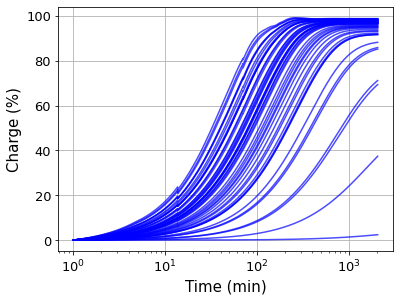

In [140]:
t = np.logspace(0, 11, 10000, base=2)
t, sol = wolfson_samples(50, sq_combi=False, t=t, tRNA_conc=5)

fig, ax1 = plot_S(t, sol, 4)
fig.savefig('Substrate_5p_50n.pdf')

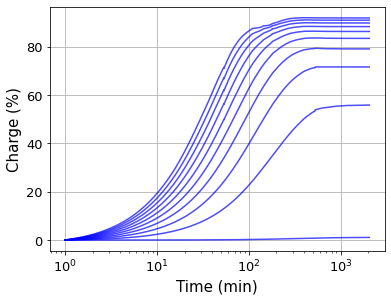

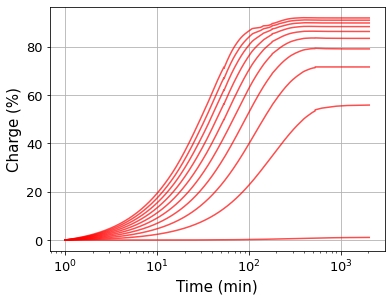

In [185]:
Nt = 10
min_k1 = 10000
k1_arr = np.linspace(min_k1, 1e7, Nt)
S0_arr = np.random.normal(1, 0.5, Nt)
S0_arr[S0_arr<0.1] = 1
S0_arr = S0_arr/sum(S0_arr) * 1e-6 * 5

# Plot the model:
t = np.logspace(0, 11, 10000, base=2)
_, sol = sol_p3_n_on(k1_arr, S0_arr, t=t)
fig, ax1 = plot_S(t, sol, 3)
fig.savefig('Substrate_3p_10n.pdf')

# Plot the inferred
p_fun = fit_p3_n_data(sol, Nt, min_k1, S0_arr, t)
_, sol_inf = sol_p3_n_on(p_fun.x, S0_arr, t=t)
fig_inf, ax1_inf = plot_S(t, sol_inf, 3, color='r')
fig_inf.savefig('Substrate_3p_10n_inferred.pdf')